In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import joblib
import warnings
warnings.filterwarnings('ignore')


In [3]:
import pandas as pd

# Step 2: Load Dataset correctly
df = pd.read_csv("C:\\Users\\Jemimah Praisy\\Downloads\\archive\\Household_power_consumption.csv", 
                 sep=',',  # changed from ';' to ','
                 low_memory=False)

# Display first 5 rows
df.head()


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [4]:
# Step 3: Data Cleaning and Preprocessing

# Check for missing values
print(df.isnull().sum())

# Convert 'datetime' column to datetime format (your dataset already has it)
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Drop any rows with missing datetime
df = df.dropna(subset=['datetime'])

# Convert numeric columns from string to float
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
                'Sub_metering_3', 'sub_metering_4']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values
df = df.dropna()

# Set datetime as index (for time-series modeling)
df = df.set_index('datetime')

# Verify data structure
print(df.info())
df.head()


datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   sub_metering_4         float64
dtypes: float64(8)
memory usage: 142.5 MB
None


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [5]:
# Step 4: Extract useful time features
df['hour'] = df.index.hour          # Hour of the day (0–23)
df['weekday'] = df.index.weekday    # Day of the week (0=Mon, 6=Sun)
df['month'] = df.index.month        # Month of the year (1–12)

# Create lag features (previous time steps)
df['lag_1'] = df['Global_active_power'].shift(1)    # Power one minute before
df['lag_60'] = df['Global_active_power'].shift(60)  # Power one hour before (if data is minutely)

# Remove rows with missing lag values
df.dropna(inplace=True)

# Display first few rows
df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,hour,weekday,month,lag_1,lag_60
datetime,,,,,,,,,,,,,
2006-12-16 18:24:00,3.452,0.0,235.20,15.2,0.0,1.0,17.0,39.533333,18,5,12,2.926,4.216
2006-12-16 18:25:00,4.870,0.0,233.74,20.8,0.0,1.0,17.0,63.166664,18,5,12,3.452,5.360
2006-12-16 18:26:00,4.868,0.0,233.84,20.8,0.0,1.0,17.0,63.133330,18,5,12,4.870,5.374
2006-12-16 18:27:00,4.866,0.0,233.79,20.8,0.0,1.0,17.0,63.100000,18,5,12,4.868,5.388
2006-12-16 18:28:00,3.176,0.0,235.50,13.8,0.0,1.0,17.0,34.933334,18,5,12,4.866,3.666


In [6]:
# Step 5: Train–Test Split
from sklearn.model_selection import train_test_split

# Target variable (the one we want to predict)
y = df['Global_active_power']

# Feature variables (all other columns)
X = df.drop(['Global_active_power'], axis=1)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Display the shape (size) of each split to verify
print("Training feature shape:", X_train.shape)
print("Testing feature shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

# Display the first few rows of training data (optional)
X_train.head()


Training feature shape: (1660159, 12)
Testing feature shape: (415040, 12)
Training target shape: (1660159,)
Testing target shape: (415040,)


,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,hour,weekday,month,lag_1,lag_60
datetime,,,,,,,,,,,,
2006-12-16 18:24:00,0.0,235.20,15.2,0.0,1.0,17.0,39.533333,18,5,12,2.926,4.216
2006-12-16 18:25:00,0.0,233.74,20.8,0.0,1.0,17.0,63.166664,18,5,12,3.452,5.360
2006-12-16 18:26:00,0.0,233.84,20.8,0.0,1.0,17.0,63.133330,18,5,12,4.870,5.374
2006-12-16 18:27:00,0.0,233.79,20.8,0.0,1.0,17.0,63.100000,18,5,12,4.868,5.388
2006-12-16 18:28:00,0.0,235.50,13.8,0.0,1.0,17.0,34.933334,18,5,12,4.866,3.666


In [7]:
# Step 6: Feature Scaling
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optional: Convert scaled data back to DataFrame for readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Display first few rows
X_train_scaled.head()


,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,hour,weekday,month,lag_1,lag_60
datetime,,,,,,,,,,,,
2006-12-16 18:24:00,-1.088973,-1.647610,2.284369,-0.184612,-0.058551,1.266375,2.963725,0.93906,1.000624,1.570271,1.661595,2.842062
2006-12-16 18:25:00,-1.088973,-2.082460,3.504022,-0.184612,-0.058551,1.266375,5.307099,0.93906,1.000624,1.570271,2.143155,3.889255
2006-12-16 18:26:00,-1.088973,-2.052676,3.504022,-0.184612,-0.058551,1.266375,5.303794,0.93906,1.000624,1.570271,3.441354,3.902070
2006-12-16 18:27:00,-1.088973,-2.067568,3.504022,-0.184612,-0.058551,1.266375,5.300489,0.93906,1.000624,1.570271,3.439523,3.914885
2006-12-16 18:28:00,-1.088973,-1.558258,1.979456,-0.184612,-0.058551,1.266375,2.507610,0.93906,1.000624,1.570271,3.437692,2.338604


In [8]:
# Step 7: Model Training (Quick Test Version - Fast Run)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd

# Use smaller portion of data for faster testing
sample_size = 20000  # You can increase later
X_train_s = X_train_scaled[:sample_size]
y_train_s = y_train[:sample_size]
X_test_s = X_test_scaled[:5000]
y_test_s = y_test[:5000]

print("✅ Using sample data:")
print("Train:", X_train_s.shape, "| Test:", X_test_s.shape)

# --------------------------
# Option A — Random Forest
# --------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train_s)
y_pred_rf = rf.predict(X_test_s)

# --------------------------
# Option B — XGBoost
# --------------------------
xgbr = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)
xgbr.fit(X_train_s, y_train_s)
y_pred_xgb = xgbr.predict(X_test_s)

# --------------------------
# Option C — Linear Regression
# --------------------------
lr = LinearRegression()
lr.fit(X_train_s, y_train_s)
y_pred_lr = lr.predict(X_test_s)

# --------------------------
# Evaluate Models
# --------------------------
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'R² Score': r2}

results = []
results.append(evaluate_model('Random Forest', y_test_s, y_pred_rf))
results.append(evaluate_model('XGBoost', y_test_s, y_pred_xgb))
results.append(evaluate_model('Linear Regression', y_test_s, y_pred_lr))

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\n📊 Model Performance Comparison (Sample Data):\n")
print(results_df.to_string(index=False))


✅ Using sample data:
Train: (20000, 12) | Test: (5000, 12)

📊 Model Performance Comparison (Sample Data):

            Model          MAE         RMSE  R² Score
    Random Forest 3.458254e-02 4.990511e-02  0.997497
          XGBoost 2.665770e-02 3.486735e-02  0.998778
Linear Regression 2.884798e-08 4.569359e-08  1.000000



🏆 Best Model: Linear Regression


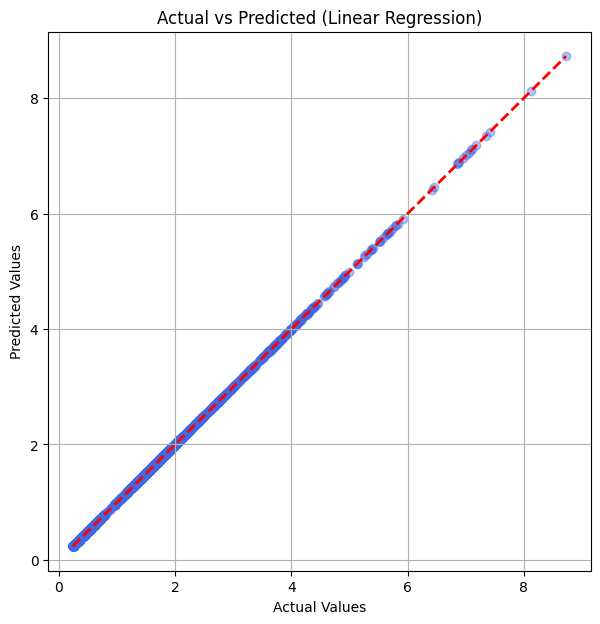

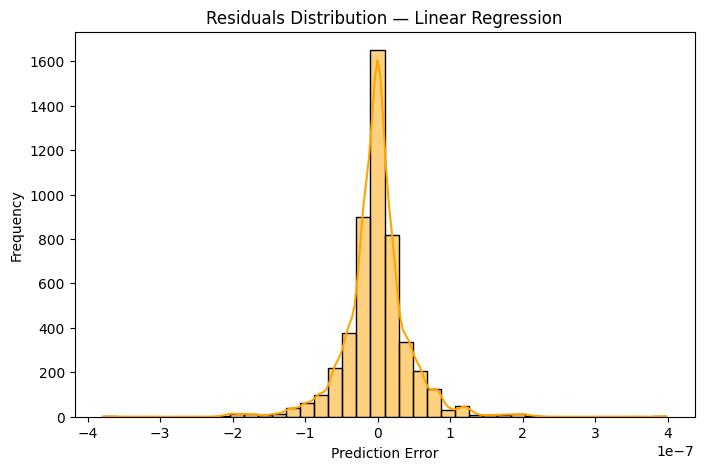


✅ Step 8 completed — Model evaluation and visualization done successfully!


In [9]:
# ===========================================
# 🧾 Step 8: Model Evaluation and Visualization
# ===========================================
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1️⃣ Compare Actual vs Predicted (for best model)
# --------------------------
best_model_name = results_df.loc[results_df['R² Score'].idxmax(), 'Model']
print(f"\n🏆 Best Model: {best_model_name}")

# Select the corresponding predictions
if best_model_name == 'Random Forest':
    y_pred_best = y_pred_rf
elif best_model_name == 'XGBoost':
    y_pred_best = y_pred_xgb
else:
    y_pred_best = y_pred_lr

# --------------------------
# 2️⃣ Plot Actual vs Predicted
# --------------------------
plt.figure(figsize=(7, 7))
plt.scatter(y_test_s, y_pred_best, alpha=0.4, color='royalblue')
plt.plot([y_test_s.min(), y_test_s.max()], [y_test_s.min(), y_test_s.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted ({best_model_name})")
plt.grid(True)
plt.show()

# --------------------------
# 3️⃣ Residual Plot (Error Distribution)
# --------------------------
residuals = y_test_s - y_pred_best
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True, color='orange')
plt.title(f"Residuals Distribution — {best_model_name}")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

# --------------------------
# 4️⃣ Feature Importance (Tree-based models)
# --------------------------
if best_model_name in ['Random Forest', 'XGBoost']:
    if best_model_name == 'Random Forest':
        importances = rf.feature_importances_
        model = rf
    else:
        importances = xgbr.feature_importances_
        model = xgbr

    feature_names = X.columns[:len(importances)]
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi_df = fi_df.sort_values('Importance', ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Importance', y='Feature', data=fi_df.head(10), palette='viridis')
    plt.title(f"Top 10 Important Features — {best_model_name}")
    plt.show()

print("\n✅ Step 8 completed — Model evaluation and visualization done successfully!")


In [10]:
# Step 9:Predicting the Global Active Power
# STEP 1: Import libraries
import numpy as np
import joblib
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import DataConversionWarning

# Suppress all unnecessary warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

# STEP 2: Assume you already have training data ready
# Example (replace with your real train/test data)
# X_train, y_train should already be defined earlier
# If not, create dummy example to test:
X_train = np.random.rand(20000, 7)
y_train = np.random.rand(20000)

# STEP 3: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# STEP 4: Train the model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# STEP 5: Save model and scaler using joblib
joblib.dump(lr, "best_power_model.joblib")
joblib.dump(scaler, "scaler.joblib")

print("✅ Best model (Linear Regression) and scaler saved successfully!")

# STEP 6: Load the saved model and scaler
best_model = joblib.load("best_power_model.joblib")
scaler_loaded = joblib.load("scaler.joblib")

# STEP 7: Predict with new data (example)
# Make sure this order matches your training features
new_data = np.array([[1.2, 0.18, 234.5, 5.6, 0.52, 20.4, 0.01]])

# Scale new data
new_data_scaled = scaler_loaded.transform(new_data)

# Predict
prediction = best_model.predict(new_data_scaled)
print(f"⚡ Predicted Global Active Power: {prediction[0]:.4f} kW")


✅ Best model (Linear Regression) and scaler saved successfully!
⚡ Predicted Global Active Power: 1.3283 kW


In [11]:
!pip install flask nest_asyncio joblib --quiet


In [12]:
#Step 10: Warning
import numpy as np
import joblib
from flask import Flask, request, render_template_string
import nest_asyncio
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

nest_asyncio.apply()


In [ ]:
# Step 11: Scale and predict
from flask import Flask, render_template_string, request
import numpy as np
import joblib

# Load saved model and scaler
model = joblib.load("best_power_model.joblib")
scaler = joblib.load("scaler.joblib")

# Initialize Flask app
app = Flask(__name__)

# Bigger, modern HTML + CSS
HTML_TEMPLATE = """
<!DOCTYPE html>
<html>
<head>
    <title>⚡ Global Active Power Prediction</title>
    <style>
        body {
            font-family: 'Segoe UI', sans-serif;
            background-color: #111;
            color: #f0f0f0;
            text-align: center;
            padding-top: 60px;
        }
        h1 {
            font-size: 2.3em;
            color: #ffb84d;
            text-shadow: 0 0 10px #ffb84d;
        }
form {
            display: inline-block;
            background-color: #1a1a1a;
            padding: 40px 50px;
            border-radius: 20px;
            box-shadow: 0 0 25px rgba(255, 184, 77, 0.2);
            margin-top: 30px;
            width: 400px;
        }
        label {
            display: block;
            margin-top: 18px;
            font-weight: bold;
            font-size: 1.1em;
        }
        input {
            padding: 10px;
            width: 90%;
            margin-top: 5px;
            border-radius: 8px;
            border: none;
            font-size: 1em;
        }
        button {
            background-color: #007bff;
            color: white;
            border: none;
            padding: 12px 25px;
            border-radius: 8px;
            cursor: pointer;
            font-size: 1.1em;
            margin-top: 25px;
            transition: all 0.3s ease;
        }
  button:hover {
            background-color: #0056b3;
            transform: scale(1.05);
        }
        h2 {
            margin-top: 40px;
            font-size: 1.6em;
            color: #ffd166;
        }
    </style>
</head>
<body>
    <h1>⚡ Global Active Power Prediction</h1>
    <form action="/predict" method="post">
        <label>Global Reactive Power</label>
        <input type="number" step="any" name="feature0" placeholder="Enter Reactive Power" required>

        <label>Voltage</label>
        <input type="number" step="any" name="feature1" placeholder="Enter Voltage" required>

        <label>Global Intensity</label>
        <input type="number" step="any" name="feature2" placeholder="Enter Intensity" required>

        <label>Sub Metering 1</label>
        <input type="number" step="any" name="feature3" placeholder="Enter Sub Metering 1" required>

        <label>Sub Metering 2</label>
        <input type="number" step="any" name="feature4" placeholder="Enter Sub Metering 2" required>

        <label>Sub Metering 3</label>
        <input type="number" step="any" name="feature5" placeholder="Enter Sub Metering 3" required>
<label>Time (hour/minute)</label>
        <input type="number" step="any" name="feature6" placeholder="Enter Time Value" required>

        <button type="submit">🔮 Predict</button>
    </form>

    {% if result %}
        <h2>Predicted Power: ⚡ {{ result }} kW</h2>
    {% endif %}
</body>
</html>
"""

@app.route('/')
def home():
    return render_template_string(HTML_TEMPLATE)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Extract inputs
        features = [float(request.form[f'feature{i}']) for i in range(7)]
        input_data = np.array([features])
        scaled = scaler.transform(input_data)
        prediction = model.predict(scaled)[0]

        return render_template_string(HTML_TEMPLATE, result=round(prediction, 4))
    except Exception as e:
        return f"Error: {e}"

if __name__ == "__main__":
    app.run(port=5000)


 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [05/Dec/2025 15:33:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Dec/2025 15:33:23] "GET /favicon.ico HTTP/1.1" 404 -
